# PREDICTION FOR "Failure Type" : FIRST MODELS

As first predictions for the second output feature "Failure Type", we will test our first models by applying a cross validation and see which portion of the dataset it is the most relevant to use.
This prediction depends on the value of Target so we will predict Failure Type only if the value of Target=1 (meaning there is a failure). But to choose the models, we will only keep the row of Failure Type to predict its value, considering the Target has already been predicted. 

As this is a multi-class prediction, we will compare Balanced Accuracy which is average of Recall, in addition to other metrics saw in the Target prediction.

In [55]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Loading our dataset

In [5]:
X_train = pd.read_csv('X_train.csv', sep=',')
X_train_smote = pd.read_csv('X_train_resampled_failure_type.csv', sep=',')
#for XGBoost prediction
X_train.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train.columns]
X_train_smote.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train.columns]

y_train_full = pd.read_csv('y_train.csv', sep=',') #with Target AND Failure Type row
y_train = y_train_full['Failure Type'] #just with Failure Type row
y_train_resampled = pd.read_csv('y_train_resampled_failure_type.csv', sep=',')
y_train_smote = y_train_resampled['Failure Type']
y_train.columns = ['Failure_Type']
y_train_smote.columns = ['Failure_Type']


In [7]:
X_train_smote.columns

Index(['Type', 'Air_temperature_K', 'Process_temperature_K',
       'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min'],
      dtype='object')

In [24]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
7973    1
7974    1
7975    4
7976    1
7977    1
Name: Failure Type, Length: 7978, dtype: int64

Pipeline of the models

Note: for each tree based model, as we use the original dataset, to avoid problem due to the imbalance, we add a parameter like class_weight

In [40]:
#for models using dependencies between columns and which need their names
def restore_cols(X):
    return pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])


#weight class for CatBoost preidiction:
counts = np.bincount(y_train) 
total = len(y_train)
n_classes = len(counts)
class_weigth_catboost = [total / (n_classes * c) if c != 0 else 1.0 for c in counts]

#stocking our different pipelines in a dict: first, the models using smote dataset
pipelines_smote = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=500, multi_class="ovr")) #to use a binary conversion for each class
    ]),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(kernel="rbf", probability=True))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(n_neighbors=5))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPClassifier(hidden_layer_sizes=(50,50),
                                max_iter=1000,
                                learning_rate_init=0.01,
                                early_stopping=True,
                                n_iter_no_change=20,
                                validation_fraction=0.1,
                                random_state=42)) #i have icreased the max iter because 300 was not enough to converge
    ])
}

#stocking our different pipelines in a second dict: the models using original datase

pipelines = {
    "DecisionTree": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", DecisionTreeClassifier(class_weight='balanced'))#compensate with imbalanced dataset
    ]),

    "RandomForest": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", RandomForestClassifier(
            class_weight='balanced',#compensate with imbalanced dataset
            n_estimators=300, #more than the default value
        ))
    ]),

    "XGBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", XGBClassifier(
            n_estimators=300,
            eval_metric="mlogloss",
            tree_method="hist"   #found to be the more optimal parameters here
        ))
    ]),

    "CatBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", CatBoostClassifier(
            class_weights=class_weigth_catboost,
            logging_level="Silent" #to not print each step..
        ))
    ]),

    "LightGBM": Pipeline([
        ("scaler", StandardScaler()),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", LGBMClassifier(
            n_estimators=300,
            verbose=-1,
            class_weight='balanced'
        ))
    ])
}

Defining different values for k fold for Stratified K Fold

In [43]:
n_values = [3, 5, 10]

In [45]:
results = [] #stocking the results to print them

#call pipeline with different models and evaluating them
for name, model in pipelines_smote.items():
    print(f"\n{name} :")
    for n in n_values:
        k = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
        print(f"With {n} splits in Stratified k-Fold:")
        acc_scores = []
        prec_scores = []
        rec_scores = []
        f1_scores = []
        balanced_accuracy = []
        for train_index, val_index in k.split(X_train_smote, y_train_smote):
            X_tr, X_val = X_train_smote.iloc[train_index], X_train.iloc[val_index]
            y_tr, y_val = y_train_smote.iloc[train_index], y_train.iloc[val_index]
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
                
            acc_scores.append(accuracy_score(y_val, y_pred))
            prec_scores.append(precision_score(y_val, y_pred, average="macro", zero_division=0))
            rec_scores.append(recall_score(y_val, y_pred, average="macro", zero_division=0))
            f1_scores.append(f1_score(y_val, y_pred, average="macro", zero_division=0))
            balanced_accuracy.append(balanced_accuracy_score(y_val, y_pred))
            
        mean_acc = np.mean(acc_scores)
        mean_prec = np.mean(prec_scores)
        mean_rec = np.mean(rec_scores)
        mean_f1 = np.mean(f1_scores)
        mean_balanced_accuracy = np.mean(balanced_accuracy)

        print(f"Accuracy : {mean_acc:.4f}")
        print(f"Precision : {mean_prec:.4f}")
        print(f"Recall : {mean_rec:.4f}")
        print(f"F1-score : {mean_f1:.4f}")
        print(f"Balanceed accuracy : {mean_balanced_accuracy:.4f}")
        results.append({
            "Model": name,
            "k": n,
            "Accuracy": mean_acc,
            "Precision": mean_prec,
            "Recall": mean_rec,
            "F1": mean_f1,
            "Balanced accuracy": mean_balanced_accuracy
        })


for name, model in pipelines.items():
    print(f"\n{name} :")
    for n in n_values:
        k = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
        print(f"With {n} splits in Stratified k-Fold:")
        acc_scores = []
        prec_scores = []
        rec_scores = []
        f1_scores = []
        mean_balanced_accuracy = []
        for train_index, val_index in k.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            acc_scores.append(accuracy_score(y_val, y_pred))
            prec_scores.append(precision_score(y_val, y_pred, average="macro", zero_division=0))
            rec_scores.append(recall_score(y_val, y_pred, average="macro", zero_division=0))
            f1_scores.append(f1_score(y_val, y_pred, average="macro", zero_division=0))
            balanced_accuracy.append(balanced_accuracy_score(y_val, y_pred))
            
        mean_acc = np.mean(acc_scores)
        mean_prec = np.mean(prec_scores)
        mean_rec = np.mean(rec_scores)
        mean_f1 = np.mean(f1_scores)
        mean_balanced_accuracy = np.mean(balanced_accuracy)
        
        print(f"Accuracy   : {mean_acc:.4f}")
        print(f"Precision  : {mean_prec:.4f}")
        print(f"Recall     : {mean_rec:.4f}")
        print(f"F1-score   : {mean_f1:.4f}")
        print(f"Balanced accuracy  : {mean_balanced_accuracy:.4f}")
        results.append({
            "Model": name,
            "k": n,
            "Accuracy": mean_acc,
            "Precision": mean_prec,
            "Recall": mean_rec,
            "F1": mean_f1,
            "Balanced accuracy": mean_balanced_accuracy
        })


Logistic Regression :
With 3 splits in Stratified k-Fold:
Accuracy : 0.6803
Precision : 0.2451
Recall : 0.3829
F1-score : 0.2268
Balanceed accuracy : 0.5183
With 5 splits in Stratified k-Fold:


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packag

Accuracy : 0.6750
Precision : 0.2821
Recall : 0.3413
F1-score : 0.2510
Balanceed accuracy : 0.5507
With 10 splits in Stratified k-Fold:


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packag

Accuracy : 0.7050
Precision : 0.3333
Recall : 0.3184
F1-score : 0.2950
Balanceed accuracy : 0.7026

SVM :
With 3 splits in Stratified k-Fold:
Accuracy : 0.6202
Precision : 0.2303
Recall : 0.3905
F1-score : 0.2069
Balanceed accuracy : 0.6094
With 5 splits in Stratified k-Fold:


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packag

Accuracy : 0.6450
Precision : 0.2721
Recall : 0.3399
F1-score : 0.2486
Balanceed accuracy : 0.6312
With 10 splits in Stratified k-Fold:


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packag

Accuracy : 0.6450
Precision : 0.3147
Recall : 0.2926
F1-score : 0.2728
Balanceed accuracy : 0.6995

KNN :
With 3 splits in Stratified k-Fold:
Accuracy : 0.5152
Precision : 0.2156
Recall : 0.3032
F1-score : 0.1649
Balanceed accuracy : 0.4628
With 5 splits in Stratified k-Fold:


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packag

Accuracy : 0.5800
Precision : 0.2522
Recall : 0.3164
F1-score : 0.2130
Balanceed accuracy : 0.6027
With 10 splits in Stratified k-Fold:


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packag

Accuracy : 0.5850
Precision : 0.2886
Recall : 0.2528
F1-score : 0.2349
Balanceed accuracy : 0.6087

Neural Network :
With 3 splits in Stratified k-Fold:


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy : 0.6105
Precision : 0.3082
Recall : 0.5197
F1-score : 0.2890
Balanceed accuracy : 0.8535
With 5 splits in Stratified k-Fold:


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy : 0.7000
Precision : 0.3008
Recall : 0.4076
F1-score : 0.2912
Balanceed accuracy : 0.7576
With 10 splits in Stratified k-Fold:


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\hindi\anaconda3\Lib\site-packag

Accuracy : 0.6250
Precision : 0.3308
Recall : 0.2750
F1-score : 0.2774
Balanceed accuracy : 0.6274

DecisionTree :
With 3 splits in Stratified k-Fold:
Accuracy   : 0.9762
Precision  : 0.6572
Recall     : 0.5985
F1-score   : 0.6240
Balanced accuracy  : 0.6207
With 5 splits in Stratified k-Fold:
Accuracy   : 0.9754
Precision  : 0.6393
Recall     : 0.5935
F1-score   : 0.6111
Balanced accuracy  : 0.6132
With 10 splits in Stratified k-Fold:
Accuracy   : 0.9777
Precision  : 0.6498
Recall     : 0.5971
F1-score   : 0.6149
Balanced accuracy  : 0.6074

RandomForest :
With 3 splits in Stratified k-Fold:
Accuracy   : 0.9811
Precision  : 0.7290
Recall     : 0.5325
F1-score   : 0.6030
Balanced accuracy  : 0.6002
With 5 splits in Stratified k-Fold:
Accuracy   : 0.9801
Precision  : 0.7168
Recall     : 0.5140
F1-score   : 0.5843
Balanced accuracy  : 0.5882
With 10 splits in Stratified k-Fold:
Accuracy   : 0.9816
Precision  : 0.7272
Recall     : 0.5403
F1-score   : 0.6055
Balanced accuracy  : 0.5778

XG

Due to problem with the repartition of the class within the Stratified Fold (some class may not be representated), here is a new approach using the original dataset and applying SMOTE within each Stratified Cross Validation (only for basic models that used smote previously)

In [61]:
from imblearn.pipeline import Pipeline #changing the importation of the pipeline for it to be compatible with SMOTE and RUS

pipelines_smote_inside = {
    "Logistic Regression SMOTE": Pipeline([
        ("scaler", StandardScaler()),
        ("rus", RandomUnderSampler(sampling_strategy="auto", random_state=42)),
        ("smote", SMOTE(sampling_strategy="auto", random_state=42)),
        ("model", LogisticRegression(max_iter=500, multi_class="ovr")) #to use a binary conversion for each class
    ]),
    "SVM SMOTE": Pipeline([
        ("scaler", StandardScaler()),
        ("rus", RandomUnderSampler(sampling_strategy="auto", random_state=42)),
        ("smote", SMOTE(sampling_strategy="auto", random_state=42)),
        ("model", SVC(kernel="rbf", probability=True))
    ]),
    "KNN SMOTE": Pipeline([
        ("scaler", StandardScaler()),
        ("rus", RandomUnderSampler(sampling_strategy="auto", random_state=42)),
        ("smote", SMOTE(sampling_strategy="auto", random_state=42)),
        ("model", KNeighborsClassifier(n_neighbors=5))
    ]),
    "Neural Network SMOTE": Pipeline([
        ("scaler", StandardScaler()),
        ("rus", RandomUnderSampler(sampling_strategy="auto", random_state=42)),
        ("smote", SMOTE(sampling_strategy="auto", random_state=42)),
        ("model", MLPClassifier(hidden_layer_sizes=(50,50),
                                max_iter=1000,
                                learning_rate_init=0.01,
                                early_stopping=True,
                                n_iter_no_change=20,
                                validation_fraction=0.1,
                                random_state=42)) #i have icreased the max iter because 300 was not enough to converge
    ])
}


for name, model in pipelines_smote_inside.items():
    print(f"\n{name} :")
    for n in n_values:
        k = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
        print(f"With {n} splits in Stratified k-Fold:")
        acc_scores = []
        prec_scores = []
        rec_scores = []
        f1_scores = []
        mean_balanced_accuracy = []
        for train_index, val_index in k.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            acc_scores.append(accuracy_score(y_val, y_pred))
            prec_scores.append(precision_score(y_val, y_pred, average="macro", zero_division=0))
            rec_scores.append(recall_score(y_val, y_pred, average="macro", zero_division=0))
            f1_scores.append(f1_score(y_val, y_pred, average="macro", zero_division=0))
            balanced_accuracy.append(balanced_accuracy_score(y_val, y_pred))
            
        mean_acc = np.mean(acc_scores)
        mean_prec = np.mean(prec_scores)
        mean_rec = np.mean(rec_scores)
        mean_f1 = np.mean(f1_scores)
        mean_balanced_accuracy = np.mean(balanced_accuracy)
        
        print(f"Accuracy   : {mean_acc:.4f}")
        print(f"Precision  : {mean_prec:.4f}")
        print(f"Recall     : {mean_rec:.4f}")
        print(f"F1-score   : {mean_f1:.4f}")
        print(f"Balanced accuracy  : {mean_balanced_accuracy:.4f}")
        results.append({
            "Model": name,
            "k": n,
            "Accuracy": mean_acc,
            "Precision": mean_prec,
            "Recall": mean_rec,
            "F1": mean_f1,
            "Balanced accuracy": mean_balanced_accuracy
        })


Logistic Regression SMOTE :
With 3 splits in Stratified k-Fold:
Accuracy   : 0.6707
Precision  : 0.3041
Recall     : 0.8453
F1-score   : 0.3336
Balanced accuracy  : 0.6444
With 5 splits in Stratified k-Fold:
Accuracy   : 0.6973
Precision  : 0.3196
Recall     : 0.8793
F1-score   : 0.3591
Balanced accuracy  : 0.6553
With 10 splits in Stratified k-Fold:
Accuracy   : 0.6984
Precision  : 0.3151
Recall     : 0.8825
F1-score   : 0.3548
Balanced accuracy  : 0.6746

SVM SMOTE :
With 3 splits in Stratified k-Fold:
Accuracy   : 0.6037
Precision  : 0.2847
Recall     : 0.7969
F1-score   : 0.2936
Balanced accuracy  : 0.6776
With 5 splits in Stratified k-Fold:
Accuracy   : 0.6364
Precision  : 0.3012
Recall     : 0.8274
F1-score   : 0.3230
Balanced accuracy  : 0.6835
With 10 splits in Stratified k-Fold:
Accuracy   : 0.6463
Precision  : 0.2991
Recall     : 0.8417
F1-score   : 0.3233
Balanced accuracy  : 0.6952

KNN SMOTE :
With 3 splits in Stratified k-Fold:
Accuracy   : 0.5504
Precision  : 0.2736
Rec

Comparison of each models (simple models and ensemble models)

In [63]:
results_df = pd.DataFrame(results)
print(results_df)

                        Model   k  Accuracy  Precision    Recall        F1  \
0         Logistic Regression   3  0.680311   0.245139  0.382915  0.226818   
1         Logistic Regression   5  0.675000   0.282143  0.341305  0.250991   
2         Logistic Regression  10  0.705000   0.333333  0.318421  0.294997   
3                         SVM   3  0.620157   0.230313  0.390467  0.206871   
4                         SVM   5  0.645000   0.272083  0.339919  0.248622   
5                         SVM  10  0.645000   0.314722  0.292588  0.272765   
6                         KNN   3  0.515227   0.215584  0.303157  0.164871   
7                         KNN   5  0.580000   0.252222  0.316383  0.213000   
8                         KNN  10  0.585000   0.288571  0.252820  0.234939   
9              Neural Network   3  0.610508   0.308154  0.519697  0.289031   
10             Neural Network   5  0.700000   0.300833  0.407578  0.291156   
11             Neural Network  10  0.625000   0.330833  0.275009

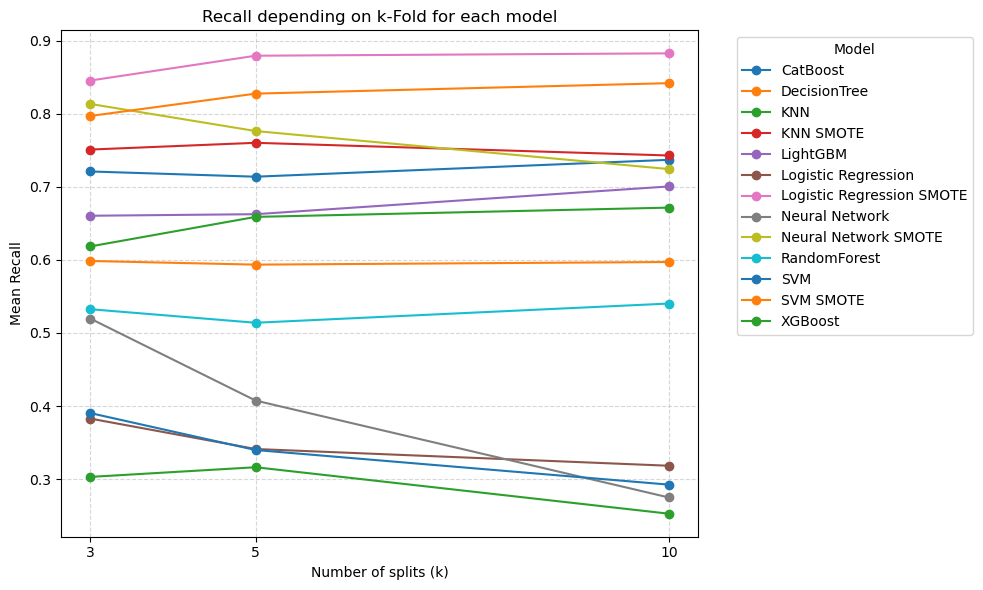

In [65]:
pivot_df = results_df.pivot(index="k", columns="Model", values="Recall")

plt.figure(figsize=(10, 6))

for model in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[model],
        marker="o",
        label=model
    )

plt.title("Recall depending on k-Fold for each model")
plt.xlabel("Number of splits (k)")
plt.ylabel("Mean Recall")
plt.xticks(pivot_df.index)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Analysis

For "Failure Type" prediction:
- Highest Recall: **LogReg, SVM, NN** 
- Highest precision: **Random Forest**
- Highest Accuracy: **LightGBM**
- Highest Balanced accuracy: **Neural Network**

Then, we found the best values for the number of splits for our Stratified Cross Validations:

For "Failure Type" prediction:
- Logistic Regression with resampling within pipeline : k = 10
- SVM with resampling within pipeline : k = 10
- Neural Network with resampling within pipeline : k = 3

To conclude, the most accurate models for our prediction of "Failure Type" are **Logistic Regression**, **SVM** and **Neural Network**, all with resampling within pipeline.

Now, we will try to optimize the parameters input for each model with GridSearch in the next notebook.

All the selected models will be put in a Voting Classifier to converge toward the most accurate prediction.